<img style="float: right;" src="https://cdn.mantelligence.com/wp-content/uploads/2017/11/Best-Beer-of-the-Month-Club-In-Depth-Beer-Club-Reviews.jpg" width= "400"/>  
  

# Decision Tree Regression & Beer Reviews  
  

---  
  
**By: Heather M. Steich, M.S.**  
**Date: March 30$^{th}$, 2018**  
**Written in: Python 3.4.5** 

In [5]:
import sys
print(sys.version)

3.4.5 | packaged by conda-forge | (default, Sep  8 2016, 14:36:52) [MSC v.1600 64 bit (AMD64)]


# Instructions
 
The following dataset consists of $1.5^+ million$ beer reviews from [beeradvocate.com](https://www.beeradvocate.com/): 
 - [https://s3.amazonaws.com/demo- datasets/beer_reviews.tar.gz](https://s3.amazonaws.com/demo- datasets/beer_reviews.tar.gz)  
  
Document your thought process as you answer these questions. Include any plots used to support your answers and provide the code, either packaged with the analysis as a markdown or notebook file or separately in a code file.  

---  
  
# Initial Setup  
  
  
 - Load analytic libraries  
 - Establish plot formatting  
 - Load the data  
  

This submission was created with a Jupyter Notebook.  There are no special instructions for running the code, as long as one has all the required libraries installed.  All the utilized Python libraries and visualization templates are included in the following code block; once run successfully, the rest of the notebook should run and compile without difficulty.  Since these libraries are all open source, I've included links to the source documentation for each below.  
  

 - Data wrangling & processing:  
    - [NumPy](http://www.numpy.org/)  
    - [pandas](https://pandas.pydata.org/pandas-docs/stable/)  
  

 - Analysis outcome measurements:  
    - [DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
    - [uniform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html)  
    - [Mean squared error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)  


 - Plotting:  
    - [matplotlib](https://matplotlib.org/contents.html)  
    - [matplotlib.pyplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)
    - [seaborn](https://seaborn.pydata.org/)   
    - [Annotations guide](https://matplotlib.org/users/annotations_guide.html)  
  

 - Remove warning messages:  
    - [warnings](https://docs.python.org/3.1/library/warnings.html)  
    - [warnings.filterwarnings('ignore')](https://docs.python.org/3.1/library/warnings.html#warnings.filterwarnings)  
  

Although I did not specifically reference on each plot, I did utilize [ColorBrewer2](http://colorbrewer2.org/) on several occasions when selecting colors from color palates that work well together and are color blind friendly.

In [6]:
### LOAD LIBRARIES ###


# Data wrangling & processing: 
import numpy as np
import pandas as pd


# Analysis outcome measurements:  
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error


# Plotting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText


# Remove warning messages:
import warnings
warnings.filterwarnings('ignore')

In [7]:
### ESTABLISH PLOT FORMATTING ###


#mpl.rcdefaults()  # Resets plot defaults

def plt_format():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (16, 10)
    plt.rcParams['font.size'] = 16
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 32
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['legend.markerscale'] = 4
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['axes.linewidth'] = 1

#plt.rcParams.keys()  # Available rcParams
plt_format()

In [8]:
### READ IN THE DATA ###  

df = pd.read_csv('./beer_reviews/beer_reviews.csv')
df.head(2)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213


---  
  
# Data Quality Evaluation & Preparation

In [9]:
### DATASET DIMENSIONS ###

df.shape

(1586614, 13)

In [10]:
### DATA TYPES ###

df.dtypes

brewery_id              int64
brewery_name           object
review_time             int64
review_overall        float64
review_aroma          float64
review_appearance     float64
review_profilename     object
beer_style             object
review_palate         float64
review_taste          float64
beer_name              object
beer_abv              float64
beer_beerid             int64
dtype: object

**NOTE:**  
  
The columns `brewery_id`, `review_time` and `beer_beerid` were parsed as integers, but that is not the correct type.  
  
The `review_time` column is actually a datetime object but formatted in UNIX time.  This is simple to convert, and the purpose would be to make it more human readable as well as being able to utilize the datetime functionality.  That opens the potential for time series analyses and more intuitive visualizations.  
  
The ID number columns (`brewery_id` and `beer_beerid`) are neither integers nor ordinal.  Specifically, they should be categorial type, dummy variables or strings.  However, since comparison statements are so much slower on strings than integers, and because the purpose of this exercise does not include modeling, I will leave them as integer types to speed up the code.  

In [11]:
### CONVERT DATA TYPES ###

# Converting UNIX time into more human readable datetime objects:
df['review_time'] = pd.to_datetime(df['review_time'], unit='s')
print('Updated `review_time` data type: ', df.review_time.dtype, '\n')

# An example of the time difference between string & integer operations:
%timeit df.brewery_id[df.brewery_id.astype(str) == '10325']
%timeit df.brewery_id[df.brewery_id == 10325]

Updated `review_time` data type:  datetime64[ns] 

1 loop, best of 3: 1.94 s per loop
100 loops, best of 3: 2.69 ms per loop


In [12]:
### CHECK FOR MISSING DATA ###

df.isnull().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

**NOTE:**  
  
Thankfully, this is overall a very complete, with minimal missing values.  The columns `brewery_name`, `review_profilename` and `beer_abv` contain a small percentage of missing numbers, with `beer_abv` being the most significant, at just over $4.27 \%$ (calculations below).
  
Even though the missing data isn't a high percentage, I investigated if there is a way to reverse-engineer these missing points.  

 - I checked corresponding `brewery_id`s for the missing `brewery_name`s, but these IDs were unique to the missing names.  Alternatively, I also looked for matching `beer_beerid`s and / `beer-name`s.  Some of the `beer_name` features did indicate that the `brewery_name` was incorrect and to reference values for another brewery.  Due to time constraints, I did not fully validate these cross-references or impute the missing names.  
  

 - There wasn't an obvious connection between `review_profilename` and other features, except perhaps `review_time`, but investigating this was beyond the scope of this exercise.  
  

 - The `beer_abv` feature had the most significant amount of missing data.  There were some ways to cross reference the `beer_abv` to unique `beer_beerid`s, but only for $25$ of the $67,785$ values, so I did not impute them.  There were several matches on unique `beer_name`s, but after some sorting and filtering by `brewery_name`, there was no obvious trend to map the unique `brewery_name` + `beer_name` combinations to the missing `beer_abv` values.  It seems that several of the `beer_name` values are used by several breweries (hence the difference in count between `beer_name` and `beer_beerid` counts).  After exploring a few other options, I abandoned the idea of imputing these values simply due to time and scope parameters without the promise in much "lift" in my answer accuracy for this assignment.  

In [13]:
### PROPORTION OF MISSING DATA ###

print('Percentage of `brewery_name` values that are missing: ', 
      '{:.2e}'.format((df.brewery_name.isnull().sum() / df.shape[0]) * 100) + ' %')
print('Percentage of `review_profilename` values that are missing: ', 
      '{:.2e}'.format((df.review_profilename.isnull().sum() / df.shape[0]) * 100) + ' %')
print('Percentage of `beer_abv` values that are missing: ', 
      '{:.2f}'.format((df.beer_abv.isnull().sum() / df.shape[0]) * 100) + ' %')

Percentage of `brewery_name` values that are missing:  9.45e-04 %
Percentage of `review_profilename` values that are missing:  2.19e-02 %
Percentage of `beer_abv` values that are missing:  4.27 %


In [14]:
### CHECK VALUE UNIQUENESS ###

df.apply(pd.Series.nunique)

brewery_id               5840
brewery_name             5742
review_time           1577960
review_overall             10
review_aroma                9
review_appearance          10
review_profilename      33387
beer_style                104
review_palate               9
review_taste                9
beer_name               56857
beer_abv                  530
beer_beerid             66055
dtype: int64

**NOTE:**  
  
Since the columns with review scores are all floating-point numbers, this isn't as telling as when the values were integers or categorical variables.  However, what this does reveal is that there are no unique indicators in this dataset, except for the index.  In cases like this, I always like to rule out duplicated rows.  

In [15]:
### CHECK FOR DUPLICATED ENTRIES ### 

print('Number of completely duplicated rows: ', df.duplicated().sum())
print('Number of duplicated rows, if only the date is ignored: ', 
      df.duplicated(subset=df.columns[df.columns != 'review_time']).sum())

# Drop duplicated rows in-place, keeping the last instance:
df.drop_duplicates(subset=df.columns[df.columns != 'review_time'], keep='last', inplace=True)

Number of completely duplicated rows:  0
Number of duplicated rows, if only the date is ignored:  774


**NOTE:**  
  
There are some repeats from people who reviewed the same beer with the exact same ratings but at different time markers.  These duplications do not change the ratings of the beers, but they do skew the number of ratings per beer.  Therefore, I will eliminate these rows from the data.  There are various other ways to handle this (marking them as separate, looking for other dimensions for repeats, etc.), but due to the breadth of this assignment, I'll just stick to dropping them and moving on.  I'm also keeping just the last occurrence of the duplicate so that I have a record of each person's most recent activity, in case that is relevant for a later time.

In [16]:
### PRINT DESCRIPTIVE STATISTICS FOR EACH NUMERIS FEATURE ###

df.describe().loc[:, 'review_overall': 'beer_abv']

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
count,1.585840e+06,1.585840e+06,1.585840e+06,1.585840e+06,1.585840e+06,1.518078e+06
mean,3.815424e+00,3.735513e+00,3.841551e+00,3.743565e+00,3.792716e+00,7.042455e+00
std,7.206133e-01,6.975880e-01,6.160762e-01,6.821912e-01,7.319590e-01,2.322580e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00
75%,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01


---  
  
# Data Questions 
  
## 1. Which brewery produces the strongest beers by ABV%?  

In [17]:
### CHECK THE ABV PERCENTAGE AVERAGES ### 

print('Mean ABV, by `brewery_id`: ', '{:.2f}'.format(df.groupby(['brewery_id'])['beer_abv'].mean().mean()), '%')
print('Mean ABV, by `brewery_id`: ', '{:.2f}'.format(df.groupby(['brewery_name'])['beer_abv'].mean().mean()), '%')
print('Median ABV, by `brewery_name`: ', '{:.2f}'.format(df.groupby(['brewery_id'])['beer_abv'].median().median()), '%')
print('Median ABV, by `brewery_name`: ', '{:.2f}'.format(df.groupby(['brewery_name'])['beer_abv'].median().median()), '%')

Mean ABV, by `brewery_id`:  5.85 %
Mean ABV, by `brewery_id`:  5.84 %
Median ABV, by `brewery_name`:  5.40 %
Median ABV, by `brewery_name`:  5.40 %


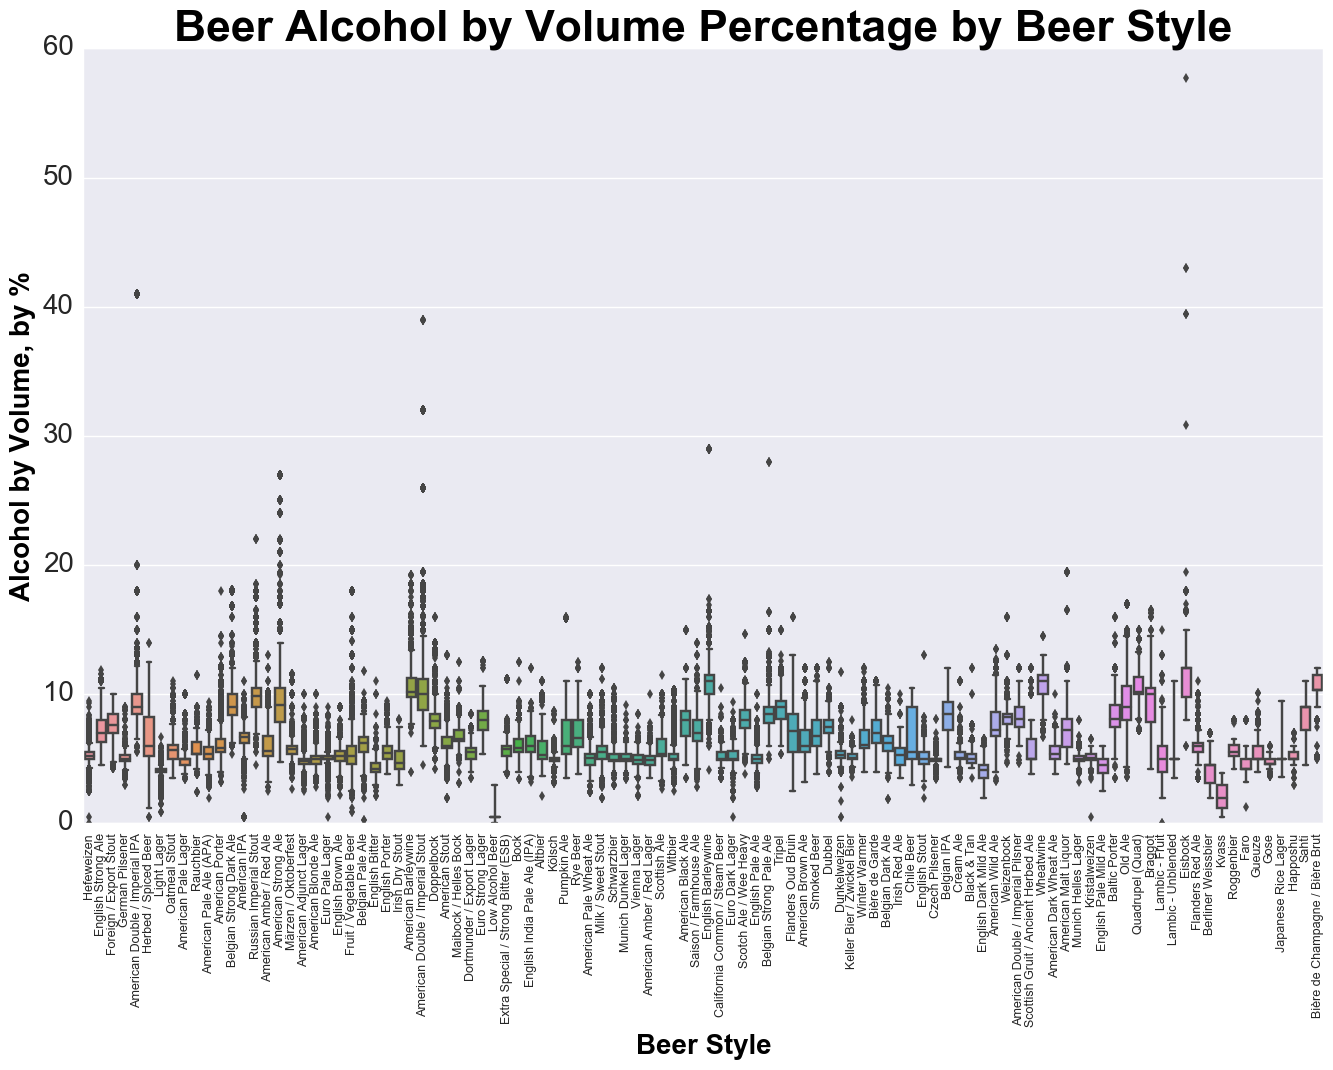

In [18]:
### PLOT ABV BY BEER STYLE ###

# Drop `beer_abv` rows containing null values:
no_nas = df[['beer_style', 'beer_abv']].dropna()

sns.boxplot(no_nas.beer_style, no_nas.beer_abv)
plt.title('Beer Alcohol by Volume Percentage by Beer Style')
plt.xlabel('Beer Style')
plt.xticks(rotation=90, fontsize=9)
plt.ylabel('Alcohol by Volume, by %');

In [19]:
### LOCATE THE STRONGEST BEERS ###

breweries = [['brewery_id'], ['brewery_name'], ['brewery_id', 'brewery_name']]
measure = ['Mean  ', 'Median', 'Total ']

for b in breweries:
    for i in range(len(measure)):
        m = measure[i]
        if i == 0:
            abv_df = df.groupby(b)['beer_abv'].mean().reset_index()   
        elif i == 1:
            abv_df = df.groupby(b)['beer_abv'].median().reset_index()
        elif i == 2: 
            abv_df = df.groupby(b)['beer_abv'].max().reset_index()
            
        
        title = abv_df[abv_df.beer_abv == abv_df.beer_abv.max()].iloc[0, 0]
        val = abv_df[abv_df.beer_abv == abv_df.beer_abv.max()].iloc[0, 1]
        if breweries.index(b) <= 1:
            print('Maximum %s ABV by %s = %s is: %s' % (m, b, title, '{:.2f}'.format(val)), '%')
        else: 
            val2 = abv_df[abv_df.beer_abv == abv_df.beer_abv.max()].iloc[0, 2]
            print('Maximum %s ABV by %s = %s, %s is: %s' % (m, b, title, val, '{:.2f}'.format(val2)), '%')
    print('\n')


Maximum Mean   ABV by ['brewery_id'] = 6513.0 is: 19.23 %
Maximum Median ABV by ['brewery_id'] = 14060.0 is: 15.20 %
Maximum Total  ABV by ['brewery_id'] = 6513.0 is: 57.70 %


Maximum Mean   ABV by ['brewery_name'] = Schorschbräu is: 19.23 %
Maximum Median ABV by ['brewery_name'] = Shoes Brewery is: 15.20 %
Maximum Total  ABV by ['brewery_name'] = Schorschbräu is: 57.70 %


Maximum Mean   ABV by ['brewery_id', 'brewery_name'] = 6513, Schorschbräu is: 19.23 %
Maximum Median ABV by ['brewery_id', 'brewery_name'] = 14060, Shoes Brewery is: 15.20 %
Maximum Total  ABV by ['brewery_id', 'brewery_name'] = 6513, Schorschbräu is: 57.70 %




**NOTE:**  
  
Breaking down the question:  
  
 - "Which brewery" could refer to `brewery_id` **or** `brewery_name`.
 - "The strongest **beer*s***" implies that I'm not just looking for the very strongest beer but rather which brewery has the portfolio with the strongest beers in total or on average.  
 - Average could be interpreted as mean or median.  
 - "Beers" are defined by `beer_name` and `beer_beerid`; there are over $9,000$ more than ID numbers than names for the beers.  However, for this problem, the actual beers do not have to be specified.  

By performing a `groupby` function, this removes the granularity of the individual reviews, which is what we need to do to answer this question.  
  
Despite the mis-match between unique `brewery_id` and `brewery_name` counts, all the groups matched the same `brewery_id` to `brewery_name`, as one would expect if the ID numbers were unique to each name.  

### ANSWER:   
  
> - The `brewery_id` and `brewery_name` with the highest **mean beer portfolio** is:  
>    - `brewery_id` = 6513
>    - `brewery_name` = Schorschbräu
>    - *Mean* `beer_abv` = 19.23 % (rounded)
  

> - The `brewery_id` and `brewery_name` with the highest **median beer portfolio** is:  
>    - `brewery_id` = 14060
>    - `brewery_name` = Shoes Brewery
>    - *Median* `beer_abv` = 15.20 % (rounded)  
  

> - The `brewery_id` and `brewery_name` with the highest **ABV beer of all** is:  
>    - `brewery_id` = 6513
>    - `brewery_name` = Schorschbräu
>    - *Maximum* `beer_abv` = 57.70 % (rounded)

---  
    
## 2. If you had to pick 3 beers to recommend using only this data, which would you pick?  

In [20]:
### BEER REVIEW COUNT STATISTICS ### 

print('Descriptive Statistics for Beer ID Review Counts:')
print(df.beer_beerid.value_counts().describe())
print('Number of Beer IDs with at Least 5 Reviews: ', 
      len(df.beer_beerid.value_counts()[df.beer_beerid.value_counts() >= 5]), '\n')
      
print('Descriptive Statistics for Beer Name Review Counts:')
print(df.beer_name.value_counts().describe())
print('Number of Beer Names with at Least 5 Reviews: ', 
      len(df.beer_name.value_counts()[df.beer_name.value_counts() >= 5]))

Descriptive Statistics for Beer ID Review Counts:
count    66055.000000
mean        24.007872
std        110.777524
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       3282.000000
Name: beer_beerid, dtype: float64
Number of Beer IDs with at Least 5 Reviews:  22371 

Descriptive Statistics for Beer Name Review Counts:
count    56857.000000
mean        27.891728
std        122.104450
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max       3282.000000
Name: beer_name, dtype: float64
Number of Beer Names with at Least 5 Reviews:  21178


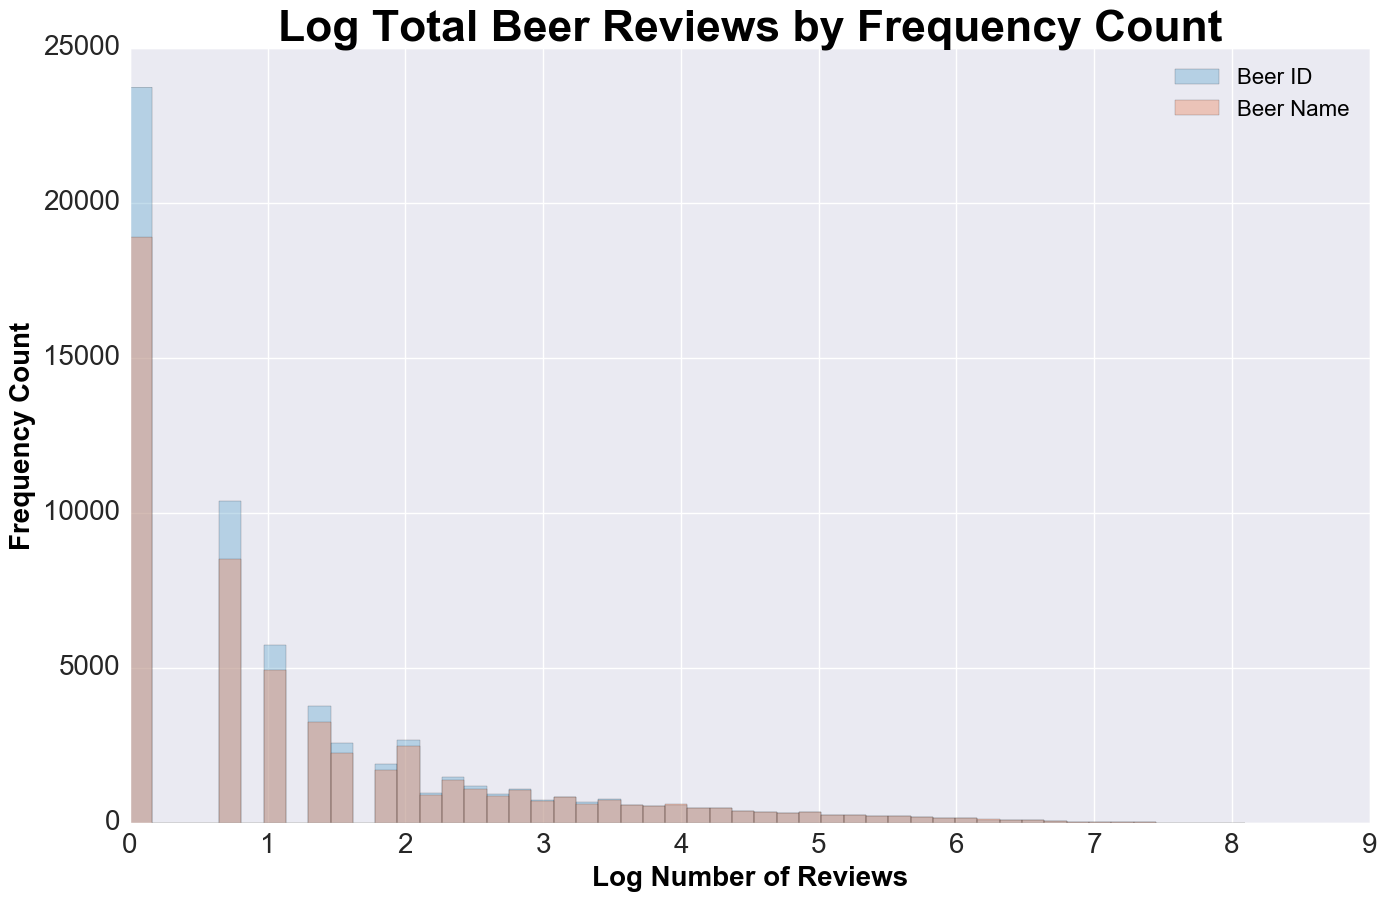

In [21]:
### PLOT NUMBER OF REVIEWS FOR EACH BEER ###

# Use pre-specified plotting parameters:
plt_format()

sns.distplot(np.log(df.beer_beerid.value_counts()), color='#67a9cf', 
             norm_hist=False, kde=False, label='Beer ID')
sns.distplot(np.log(df.beer_name.value_counts()), color='#ef8a62', 
             norm_hist=False, kde=False, label='Beer Name')
plt.title('Log Total Beer Reviews by Frequency Count')
plt.xlabel('Log Number of Reviews')
plt.ylabel('Frequency Count')
plt.legend();

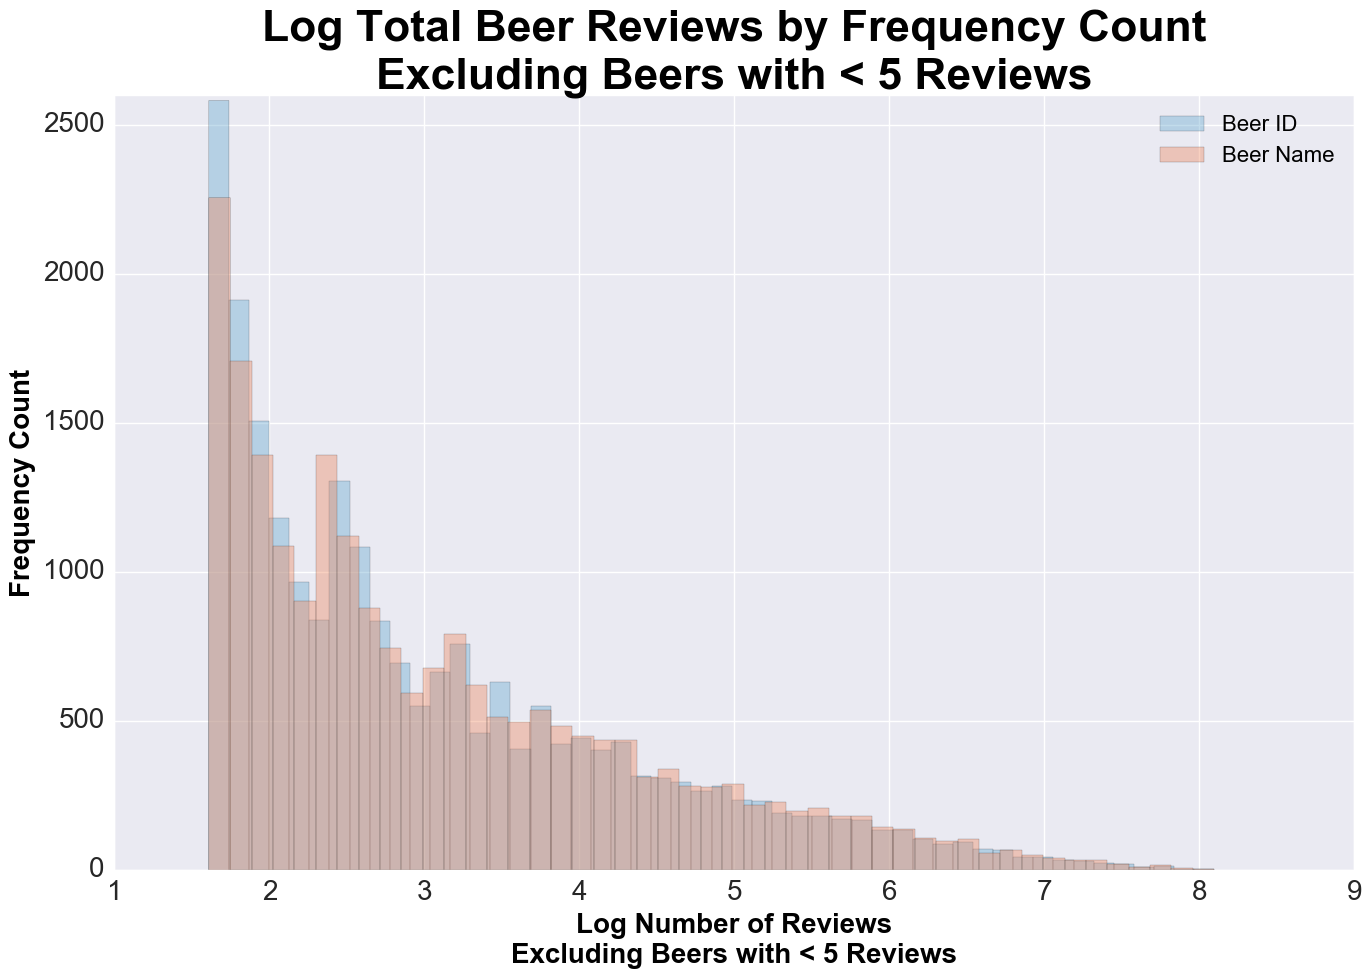

In [22]:
### PLOT NUMBER OF REVIEWS FOR EACH BEER ###

# Use pre-specified plotting parameters:
plt_format()

sns.distplot(np.log(df.beer_beerid.value_counts()[df.beer_beerid.value_counts() >= 5]), color='#67a9cf', 
             norm_hist=False, kde=False, label='Beer ID')
sns.distplot(np.log(df.beer_name.value_counts()[df.beer_name.value_counts() >= 5]), color='#ef8a62', 
             norm_hist=False, kde=False, label='Beer Name')
plt.title('Log Total Beer Reviews by Frequency Count\nExcluding Beers with < 5 Reviews')
plt.xlabel('Log Number of Reviews\nExcluding Beers with < 5 Reviews')
plt.ylabel('Frequency Count')
plt.ylim(0, 2600)
plt.legend();

**NOTE:**  

Some beers have very few reviews.  From a practicality standpoint, perhaps these beers were a limited time or quantity release, only available to small populations, unfairly priced, recalled, poorly marketed, or other reason why the reviews counts are low.  That doesn't necessarily make them bad beers, but we simply do not have enough data points about these beers to draw statistically significant conclusions about them.  

In [23]:
### REMOVE BEERS WITH LESS THAN 5 REVIEWS FROM DATAFRAME ###

# Group the data by review counts:
rev_counts = df.groupby(['beer_name'])['beer_beerid'].value_counts()
rev_counts = pd.DataFrame(rev_counts[rev_counts >= 5])
rev_counts.columns = ['counts']

# Define a new, limited DataFrame:
beer_df = df[df.beer_beerid.isin(rev_counts.reset_index().beer_beerid.values)]
print('Number of unique beer ID values in the limited dataset: ', 
      beer_df.beer_beerid.nunique())

Number of unique beer ID values in the limited dataset:  22371


In [24]:
### FIND THE BEERS WITH ALL 100% RATINGS & THE MOST NUMBER OF REVIEWS ###

# Localize beers that have all '5.0' ratings across the board:
highest_ratings = beer_df[(beer_df['review_overall'] == 5.0) & 
                          (beer_df['review_aroma'] == 5.0) & 
                          (beer_df['review_appearance'] == 5.0) & 
                          (beer_df['review_palate'] == 5.0) & 
                          (beer_df['review_taste'] == 5.0)]

# Group this data subset by `beer_name` & count how many times each beer 
# received 100% scores:
recs = pd.DataFrame(highest_ratings.groupby(['brewery_id', 'brewery_name', 'beer_name'])[
    'beer_beerid'].value_counts().sort_values(ascending=False))
recs.columns = ['100%_review_count']
recs = recs.reset_index()

# Extract the top 3 beers:
recs.iloc[:3, :]

,brewery_id,brewery_name,beer_name,beer_beerid,100%_review_count
0,863,Russian River Brewing Company,Pliny The Elder,7971,155
1,313,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,Trappist Westvleteren 12,1545,134
2,1199,Founders Brewing Company,Founders KBS (Kentucky Breakfast Stout),19960,110


**ANSWER:**  
  
> My top three recommendations would be:  
  
> 1. ***Pliny The Elder***, **by Russian River Brewing Company**  
  
> 2. ***Trappist Westvleteren 12***, **by Brouwerij Westvleteren (Sint-Sixtusabdij van Westvleteren) Brewery**  
  
> 3. ***Founders KBS (Kentucky Breakfast Stout)***, **by Founders Brewing Company**  
  

**EXPLANATION:**  
  
> Since all I am given is this dataset, I don't know who I am recommending the beers to.  For example, if it were based on *my* taste, I may think of my top three beer choices and check if they are in the dataset or not.  For the record, *Pliny the Elder* is a beer I really enjoy!  Of course, that isn't a very scientific way to go about it.  
  
> Also, if I knew who I was recommending to, and they already told me similar beers that they've enjoyed in the past, I could find search this dataset for beers in the data set that have a similar type, ABV content and good reviews.  
  
> Therefore, I am made an assumption that beers I should recommend should be based off of beers that others would recommend.  To define this, I am separating the beers that received $5.0$ rankings for *all* review factors, counting how *many* reviews of each beer fit that criteria, and recommending the top three beers from that list.  No, that isn't just a hunch I came up with; I'm basing that decision off of concepts from the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) and the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers).  I won't belabor the subjects here but will share a general overview.  
  
> The Central Limit Theorem allows one to assume that a good, representative sample will behave similarly to the entire population.  Yes, I am making a generous assumption that these $1.5^+ million$ reviews are representative of the entire beer drinking population.  This is an oversimplification because some of the [top *selling* beers in the U.S.](https://www.statista.com/statistics/188723/top-domestic-beer-brands-in-the-united-states/) are not very highly rated (see totals below).  Barring all that, I'm just going to go off the data in this table and assume that it is representative of the population, and the person(s) I am recommending too are also representative of the population.  
  
> The Law of Large Numbers gives credit that the more times an observation occurs, the more likely it is to occur again.  For this example, I'm using the beers with the highest counts of $100%$ ratings across the board.  Sure, a beer might get all high scores once or twice by a few fans, but it is less likely to continue the trend unless there are more and more instances of it happening.  That's why I chose the beers with the highest perfect number of review counts.  Here again, I'm assuming on "big;" is $110$ to $155$ reviews enough to be considered "big?"  Perhaps not, but this is the data I have to work with.  
  

**ALTERNATE APPROACHES:**  
  
> Of course, there are many ways I could have attacked this problem, but due to the breadth and importance of this assignment, I stuck to a relatively straightforward method.  I'll detail some other ideas below I had but didn't have time to code out solutions to.  
  
> - Trends by reviewer  
>    - Just as I skimmed off the beers with few reviews, it would likely be a good idea to remove reviews from reviewers who's `review_profilename` appears under a certain threshold.  
>    - Some people are inherently more positive or negative than others when responding to satisfaction rankings / surveys ([source](https://www.isixsigma.com/methodology/voc-customer-focus/how-to-avoid-the-evils-within-customer-satisfaction-surveys/)).  I would like to look for these bias trends in the `review_profilename` dimension to see if other reviews need to be eliminated.  
  

> - Trends over time
>    - Many products are subject to a ['tipping point'](https://en.wikipedia.org/wiki/The_Tipping_Point) or 'coolness factor' over time.  It would be good to investigate if such trends show up over time in the beer data.  
>    - Is there a seasonality to this data?  If so, perhaps the beers I recommend today would relate to the season.  For example, maybe crisp, light beers are more popular in the summer while heavier, higher alcohol content beers are more popular in the winter months.  *As an aside*: it could be interesting to look at this across different geographies to see if location and or temperature trends play a role in this as well, but that data is not available in this dataset.  
  

> - Sophisticated Recommendation Systems  
>    - There is plenty of research and company examples to prove the power of Recommender Systems.  A consideration here is how much time and effort are worth investing in this project algorithm?  Do we have enough data to generate a good, reliable system?  Are we going to implement this in some way to capture data on the quality of our recommendations and create a feedback loop to continuously train, strengthen and personalize the System's learning for the user (in this case, the beer connoisseur) at hand?    
>    - I would want to do some research into similar industries (such as wine, hard spirits or soda) who may have already invested a great deal of time and money into these Systems.  It's always good to learn from other people's successes and failures before trying to recreate the wheel.  

In [25]:
beers = ['Bud Light', 'Coors Light', 'Miller Light', 'Budweiser', 
         'Michelob Ultra Light']
print('Number of 5.0 reviews for:')
for b in beers:
    print('   %s =  ' % b, 
          recs[recs.beer_name.str.contains(b, case=False)
              ].brewery_name.value_counts().sum())

Number of 5.0 reviews for:
   Bud Light =   0
   Coors Light =   0
   Miller Light =   0
   Budweiser =   3
   Michelob Ultra Light =   0


---  
    
## 3. Which of the factors (aroma, taste, appearance, palette) are most important in determining the overall quality of a beer?  

**NOTE:**  
  
I am utilizing the limited `beer_df` dataset here, only considering beers with five or more reviews.  

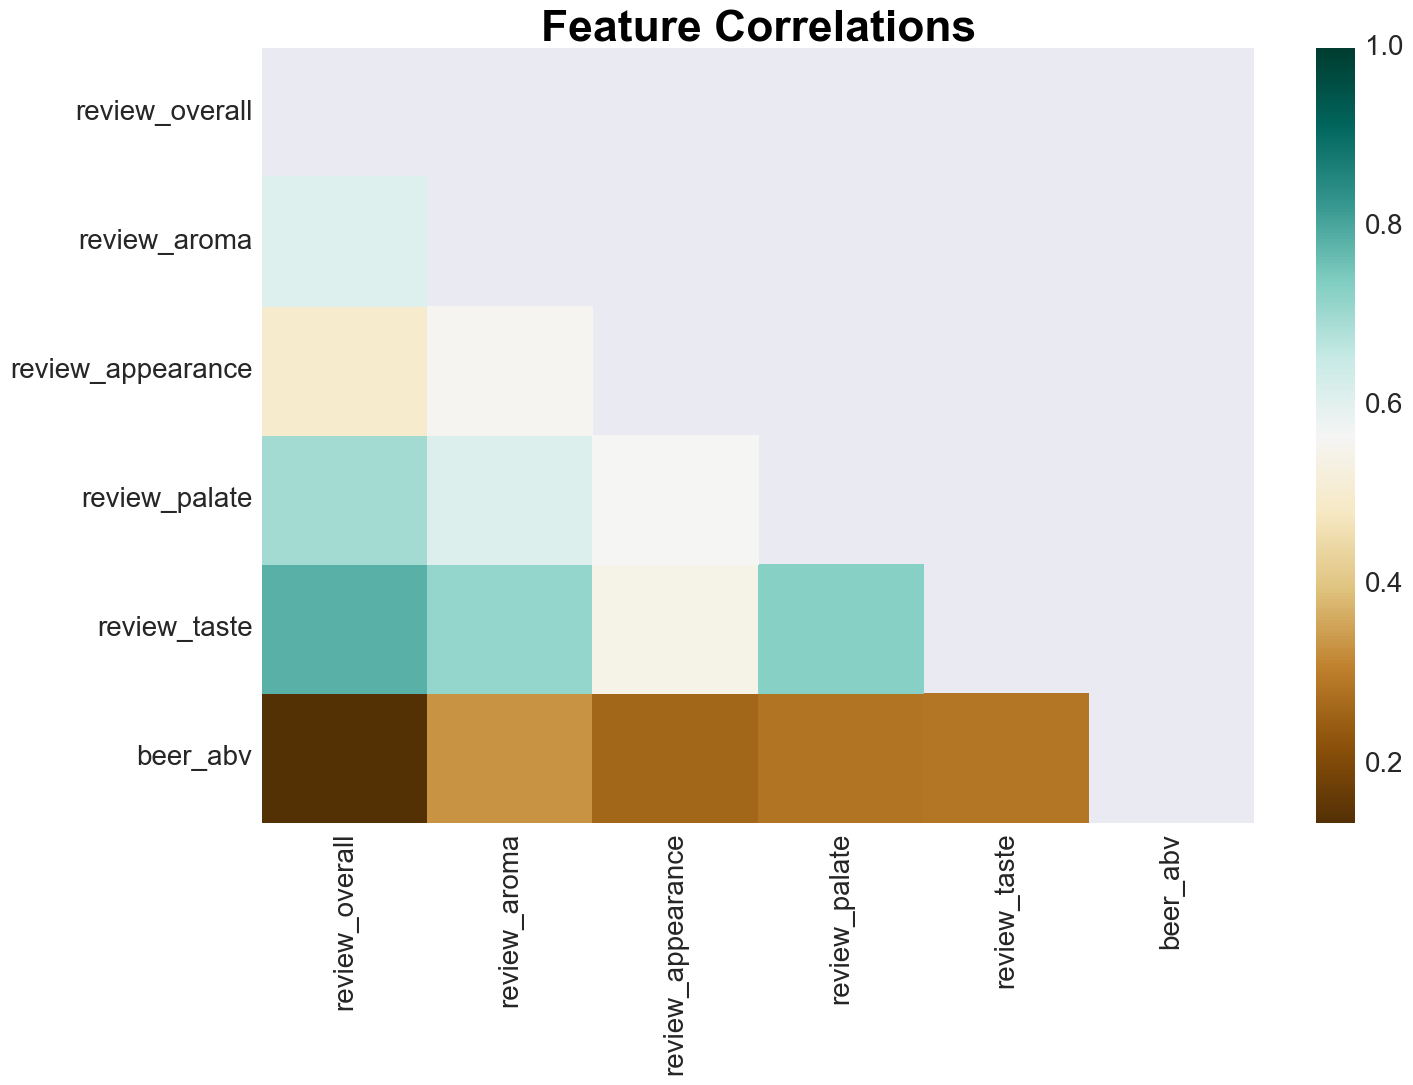

In [26]:
## CHECK FEATURE CORRELATIONS ###

# Name the potential factors: 
factors = ['review_overall', 'review_aroma', 'review_appearance', 
           'beer_style', 'review_palate', 'review_taste', 
           'beer_name', 'beer_abv', 'beer_name']

# Generate a mask to hide the duplicated values in the upper triangle:
mask = np.zeros_like(beer_df[factors].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with mask:
sns.heatmap(beer_df[factors].corr(), mask=mask, cmap='BrBG')
plt.title('Feature Correlations');

**NOTE:**  
  
I also tested the linear correlations on the grouped beer names by taking both the mean and median values for `review_overall` values and merging that back onto the `beer_df` dataset.  The purpose of that was to eliminate the potential "watering down" effect of beers with many reviews and diverse ratings.  The mean calculation helps to center the review, while the median calculation is more resistant to outliers.  
  
However, when I tested these additional features on the correlation matrix, it revealed the same features being most important, but the correlations were much weaker.  To avoid confusion and aide in visual interpretation, I've only included main features here.  

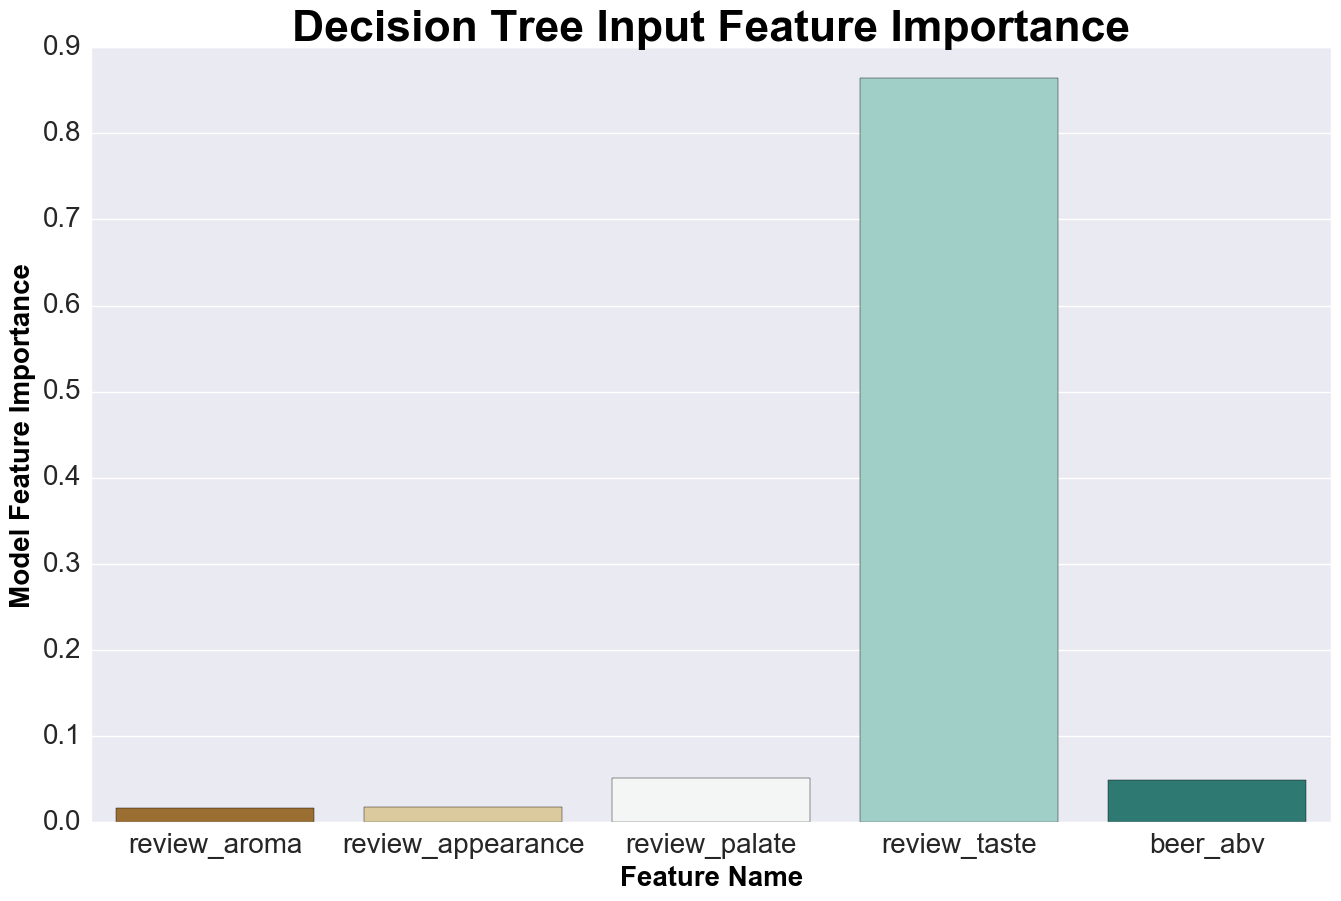

In [27]:
### MODEL FEATURE IMPORTANCE ###

# Define model input & output features:
factors = ['review_aroma', 'review_appearance', 'review_palate', 
           'review_taste', 'beer_abv', 'review_overall']
inputs = beer_df[factors].dropna()
X = inputs.iloc[:, :-1]
y = inputs.iloc[:, -1].values

# Train Decision Tree Regressor model & plot feature importances:
regr = DecisionTreeRegressor().fit(X, y)
sns.barplot(x=X.columns.values, y=(regr.feature_importances_),
            palette='BrBG')
plt.title('Decision Tree Input Feature Importance')
plt.xlabel('Feature Name')
plt.ylabel('Model Feature Importance');

### ANSWER:   
  
> From a linear correlation perspective:  
  
> - The strongest **positive correlation** to `review_overall` is `review_taste`.
  

> - The strongest **negative correlation** to `review_overall` is `beer_abv`. 
  

> - The strongest **overall correlation** to `review_overall` is `beer_abv`.
  

> - The strongest **overall correlation *of the factors in the list*** to `review_overall` is `review_taste`.
  

> From a Decision Tree model, input feature importance weight perspective:  
  
> - The **greatest feature importance** to predict `review_overall` is `review_taste`.

---  
    
# Additional Math/Coding Question (unrelated to the data)  
  
## Overview: A die is sold for cheaters which has 6 faces that are weighted unevenly so that the probability of rolling each number is not uniform. The probability of rolling each number is given in the table below.  
  

| \#  | Probability |
|-----|-------------|
|  1  |     0.34    |
|  2  |     0.18    |
|  3  |     0.05    |
|  4  |     0.18    |
|  5  |     0.13    |
|  6  |     0.12    |
 
## 4. Generate 10,000 samples using only a built-in uniform random number generator (and no other packages), from the distribution above. Explain why your approach works and illustrate with graphic(s) where appropriate.

In [28]:
### GENERATE RANDOM SAMPLES ###

# Create an empty list to hold the samples:
samples = []
generated = []

# Define a 'roll' function:
def roll(n, bias):
    
    # Continue running the function until 'n' samples are generated:
    while len(samples) < n:

        # Draw from a random, uniform distribution between [0, 1):
        randUniform = np.random.uniform()
        generated.append(randUniform)

        # Keep track of the 'bias_sum' of the bias, which has a max of 1:
        bias_sum = 0
        
        # Define the side of the die:
        side_value = 1
        
        # Loop through the respective roll outcome probabilities:
        for prob in bias:
            
            # Add the probability of the side to the running sum:
            bias_sum += prob
            
            # Check if the random value is less than the running sum:
            if randUniform < bias_sum:
                
                # Add this side's value to the list of samples & 
                # continue with the rest of the function:
                samples.append(side_value)
                break
            
            # Otherwise, increment to the next side of the die & loop 
            # again:
            side_value += 1
     
    # Return the 'n' number of samples:
    return samples
            
# Define the number of roles:
n = 10000

# Specify the biased roll probabilities:
bias = (0.34, 0.18, 0.05, 0.18, 0.13, 0.12)

# Perform the 'roll' function & verify the length of the sample:
samp = roll(n, bias)
print('Length of sample: ', len(samp))

# Create a DataFrame of the sample:
roll_df = pd.DataFrame([pd.Series(samp).value_counts(), 
                        pd.Series(samp).value_counts() / n]
                      ).T.reset_index().sort_values('index')
roll_df.columns = ['die_value', 'counts', 'percentage']
roll_df['expected_prob'] = bias

# Calculate mean-squared error:
mse = '{:.2e}'.format(mean_squared_error(roll_df.percentage, roll_df.expected_prob))
print('Mean-Squared Error: ', mse)

# Print `roll_df`:
roll_df

Length of sample:  10000
Mean-Squared Error:  6.10e-06


,die_value,counts,percentage,expected_prob
0,1,3417.0,0.3417,0.34
2,2,1752.0,0.1752,0.18
5,3,504.0,0.0504,0.05
1,4,1800.0,0.1800,0.18
3,5,1295.0,0.1295,0.13
4,6,1232.0,0.1232,0.12


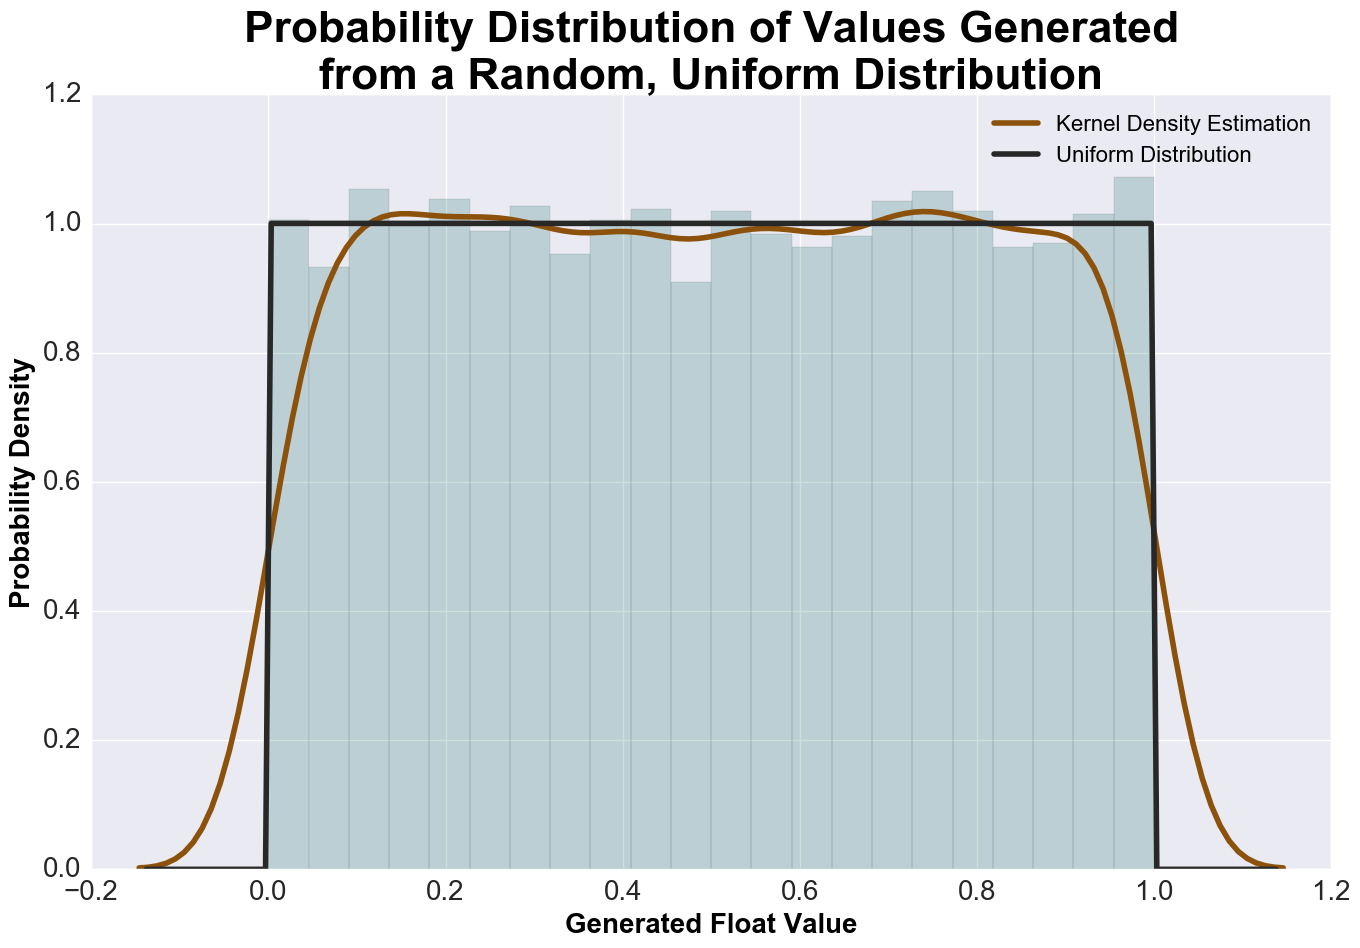

In [29]:
### PLOT ALL GENERATED VALUES ###

# Use pre-specified plotting parameters:
plt_format()

sns.distplot(generated, kde=True, fit=uniform, 
             hist_kws = {'color': '#01665e', 'alpha': 0.2},
             kde_kws={'color': '#8c510a', 'linewidth': 4, 'label': 'Kernel Density Estimation'}, 
             fit_kws={'linewidth': 4, 'label': 'Uniform Distribution'})
plt.title('Probability Distribution of Values Generated\nfrom a Random, Uniform Distribution')
plt.xlabel('Generated Float Value')
plt.ylabel('Probability Density')
plt.legend();

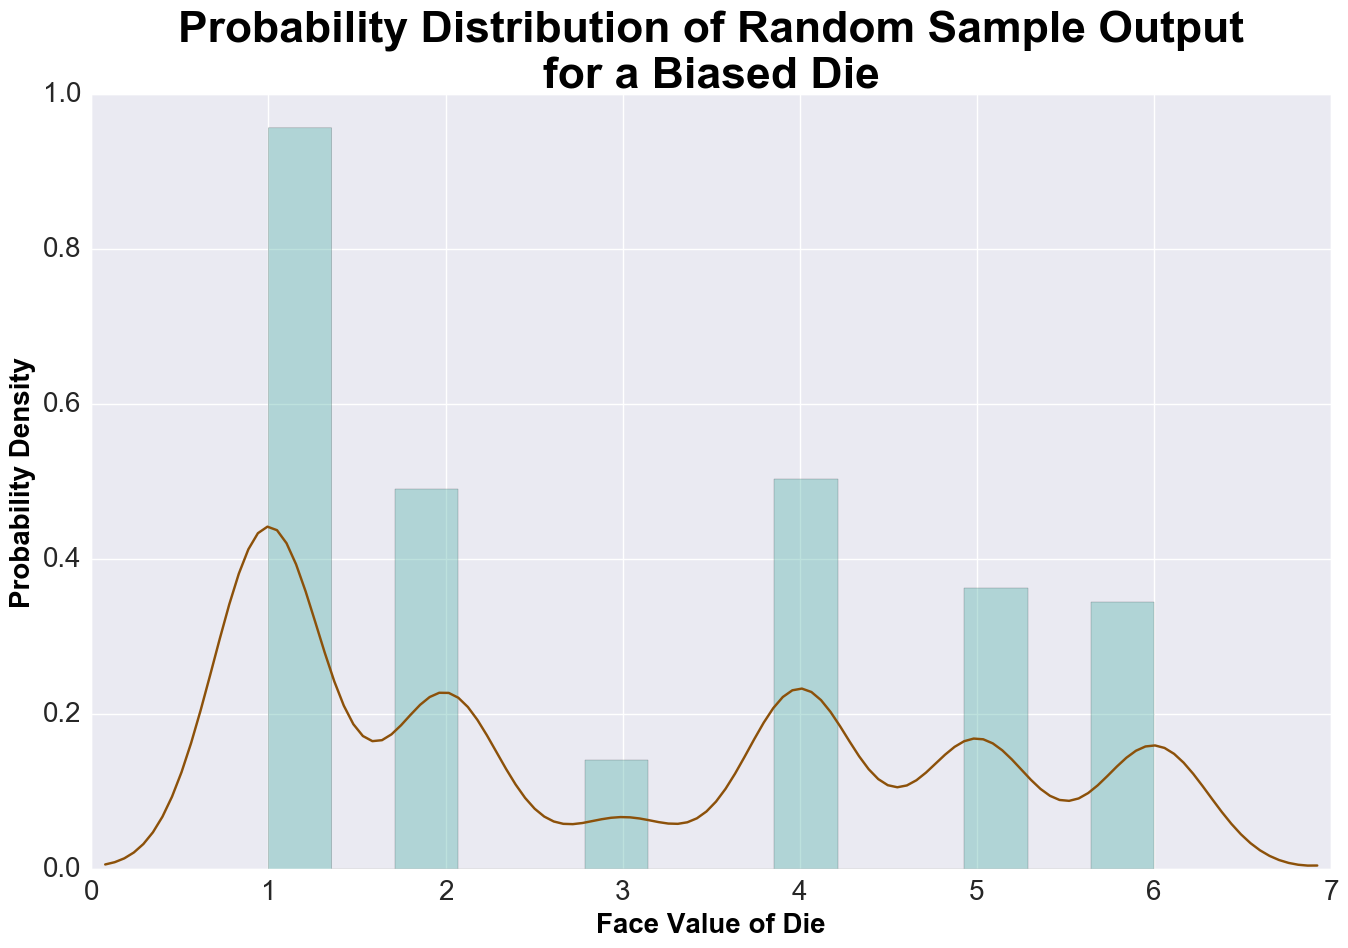

In [30]:
### PLOT SAMPLE ROLL OUTCOMES ###

# Use pre-specified plotting parameters:
plt_format()

sns.distplot(samp, hist_kws = {'color': '#5ab4ac'}, kde_kws={'color': '#8c510a'})
plt.title('Probability Distribution of Random Sample Output\nfor a Biased Die')
plt.xlabel('Face Value of Die')
plt.ylabel('Probability Density');

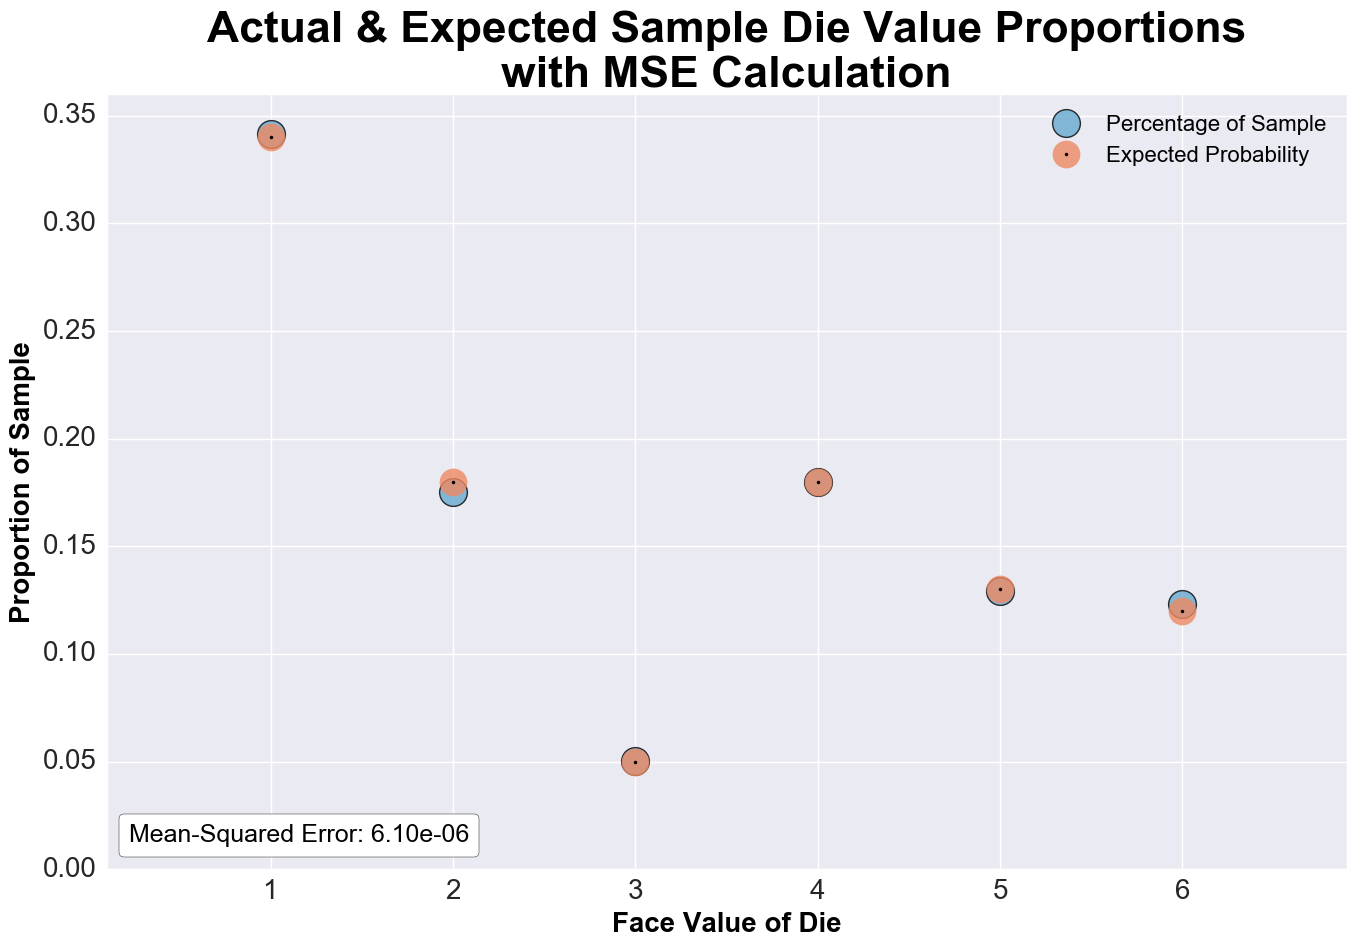

In [31]:
### PLOT SAMPLE PROPOTIONS ###

# Use pre-specified plotting parameters:
plt_format()
fig, ax = plt.subplots(1)


pts1, = plt.plot(roll_df.die_value, roll_df.percentage, 'o', 
                 markersize=20, color='#67a9cf', alpha=0.8, 
                 markeredgecolor='k', markeredgewidth=1)
pts2, = plt.plot(roll_df.die_value, roll_df.expected_prob, 'o', 
                 markersize=20, color='#ef8a62', alpha=0.8)
pts3, = plt.plot(roll_df.die_value, roll_df.expected_prob, '.', 
                 markersize=5, color='k')
plt.title('Actual & Expected Sample Die Value Proportions\nwith MSE Calculation')
plt.xlim(0.1, 6.9)
plt.xlabel('Face Value of Die')
plt.ylim(0.0, 0.36)
plt.ylabel('Proportion of Sample')


# Add mean-squared error value & legend to the plot:
at = AnchoredText('Mean-Squared Error: %s' % mse, prop=dict(size=18), 
                  frameon=True, loc=3)
at.patch.set_boxstyle("round, pad=0.0, rounding_size=0.2")
ax.add_artist(at)
plt.legend([pts1, (pts2, pts3)], 
           ['Percentage of Sample', 'Expected Probability'], 
           markerscale=1);

**APPROACH EXPLANATION:**  
  
> An *unbiased*, 6-faced die yields each face value one through six with equal probability, or a $\frac{1}{6}$ chance of rolling any face.  This is a [discrete, uniform distribution](https://en.wikipedia.org/wiki/Discrete_uniform_distribution), meaning that the random variable given as the result of the roll is distributed equally against all possible results of the die roll, one through six.
  
> The [`np.random.uniform()` command](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html) generates random samples from a uniform distribution (choosing floats in $[0, 1)$) and is the only package utilized to answer this question.  The uniform distribution is divided into six equal sections between $[0, 1)$, such as:  
  
> - $[0, \frac{1}{6})$  
  

> - $[\frac{1}{6}, \frac{2}{6})$  
  

> - $[\frac{2}{6}, \frac{3}{6})$  
  

> - $[\frac{3}{6}, \frac{4}{6})$  
  

> - $[\frac{4}{6}, \frac{5}{6})$  
  

> - $[\frac{5}{6}, 1)$  
  

> To simulate a *biased* die, the uniform distribution will need to be divided into six sections between $[0, 1)$, but this time giving each section the defined probability, such as:  
  
> - $[0, 0.34)$  
  

> - $[0.34, 0.34 + 0.18) = [0.34, 0.52)$  
  

> - $[0.52, 0.52 + 0.05) = [0.52, 0.57)$  
  

> - $[0.57, 0.57 + 0.18) = [0.57, 0.75)$  
  

> - $[0.75, 0.75 + 0.13) = [0.75, 0.88)$  
  

> - $[0.88, 0.88 + 0.12) = [0.88, 1)$  
  

> When looking at the information about a continuous, uniform distribution (https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)), the cumulative probability function will not be composed of six equal-length parts but rather of six parts which differ in length according to the probability bias assigned to this die.  
  

**ANSWER:**  
  
> As requested in the question, I've completed the following points:  
  
> - Counted that exactly $10,000$ samples were generated  
  

> - Only used a uniform random number generator and no other packages  
  

> - Verified that *all* the numbers generated fit a random, uniform distribution  
  

> - Checked that they fit the distribution specified by printing a table with the sample value percentages and the expected proportions  
  

> - Plotted the distribution of the sample, which aligns with the specified proportions  
  

> - Plotted the actual vs. expected sample proportion values & calculated the mean-squared error (MSE), which was very small  


> - Explained my approach, how it works, calculated the MSE, and illustrated with graphic as appropriate  